# Import libraries

In [1]:
'''
    Please install the following libraries before you start :
        - autograd
        - imageio
'''
import time
import numpy as np
import pandas as pd
import autograd.numpy as anp
import matplotlib.pyplot as plt

from utils import visualize_linear_reg

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, r2_score

# Introduction

# Linear Regression
## General formula
![Linear regression formula](https://miro.medium.com/max/1400/1*GSAcN9G7stUJQbuOhu0HEg.png)

## Demo
![Linear regression demo](../../media/linear_regression.gif)

## Disadvantages of linear regression
* Real-life data is not always linear, it is not practical.
* In order for OLS to be the best linear unbiased estimator (BLUE). Must satisfy a lot of condition
    - Linearity of parameters (Cannot have quadratic, cubic parameters - relationship between independent and dependent variables is ALWAYS linear)
    - Zero conditional mean of errors (The mean of errors as X progress is zero)
    - Random sampling (Data is assumed to come from a fixed predefined distribution)
    - Variance of errors is constant as X progress
    - No perfect collinearity
    - Homoskedasticity
    
=> Today we will look at a more robust and practical regression techniques - Decision Trees

# Decision Tree for regression

## 1. Overview
 - Decision tree is a machine learning method where the prediction is made by splitting data (multiple times) based on certain conditions into groups. When new data arrives, the prediction will be generated based on the group that the new data is splitted into. 

![Decison tree overview](https://lh4.googleusercontent.com/v9UQUwaQTAXVH90b-Ugyw2_61_uErfYvTBtG-RNRNB_eHUFq9AmAN_2IOdfOETnbXImnQVN-wPC7_YzDgf7urCeyhyx5UZmuSwV8BVsV8VnHxl1KtgpuxDifJ4pLE23ooYXLlnc)

## 2. How does it work? - demo example

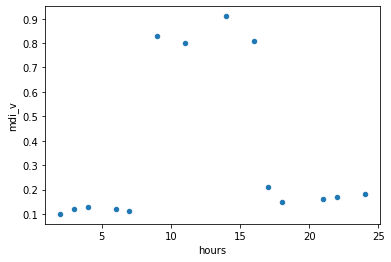

In [2]:
# Example : We want to predict the Major Depression Index (MDI) 
# based on the amount of time spent alone in a day (hours)

# Goal : Find best split that will minimize the prediction's MSE

# Approach : We will try to cut the hour values in every way to see 
# what cut results in the lowest MSE
hours = [2, 3, 4, 6, 7, 9, 11, 14, 16, 17, 18, 21, 22, 24]
mdi_v = [0.1, 0.12, 0.13, 0.12, 0.11, 0.83, 0.80, 0.91, 0.81, 0.21, 0.15, 0.16, 0.17, 0.18]

data = pd.DataFrame()
data['hours'] = hours
data['mdi_v'] = mdi_v

data.plot(kind='scatter', x='hours', y='mdi_v')
plt.show()

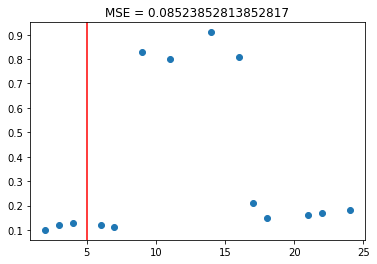

'\nQuestions that may arise :\n1. What if the data frame contain multiple columns (which is mostly the case) : Then when splitting, the algorithm\nwill identify the best split by going through all columns and all values in each column to examine the error after\nsplitting. \n\n2. What if there are a lot of numbers in the column : Then we will need discretization (assign values into bins). \nOne of my preferred approach is to use percentile values to cut the data\n\nNote : Do make jokes about my anxiety and depression\n'

In [3]:
def split(data, threshold):
    # Compute the mean of mdi of rows with hours < threshold
    lower = data[data['hours'] < threshold]['mdi_v'].mean()
    
    # Compute the mean of mdi of rows with hours > threshold
    upper = data[data['hours'] > threshold]['mdi_v'].mean()
    
    # Generate the prediction - mean of the data points in each split
    prediction = data
    prediction['prediction'] = data['hours'].apply(lambda x : lower if x < threshold else upper)
    
    # Compute the mean squared error
    mse = ((prediction['mdi_v'] - prediction['prediction']) ** 2).mean()
    
    # Visualize the result
    plt.scatter(data['hours'], data['mdi_v'])
    plt.axvline(threshold, color='red') # Draw the threshold boundary
    plt.title(f'MSE = {mse}')
    plt.show()
    
    return prediction

prediction = split(data, 5)
prediction.head()

'''
Questions that may arise :
1. What if the data frame contain multiple columns (which is mostly the case) : Then when splitting, the algorithm
will identify the best split by going through all columns and all values in each column to examine the error after
splitting. 

2. What if there are a lot of numbers in the column : Then we will need discretization (assign values into bins). 
One of my preferred approach is to use percentile values to cut the data

Note : Do make jokes about my anxiety and depression
'''

# I. Data Cleaning and feature preprocessing

In [4]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')

## 1. Handling missing values

In [5]:
imputer = SimpleImputer(strategy = 'median')
data['total_bedrooms'] = imputer.fit_transform(data['total_bedrooms'].values.reshape(-1, 1))

## 2. Handling non-numeric data

In [6]:
encoder = OrdinalEncoder()
data['ocean_proximity'] = encoder.fit_transform(data['ocean_proximity'].values.reshape(-1, 1))
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0


## 3. Handling outliers

In [7]:
# Create a function that checks for outliers in a column
def handle_outliers(data, col):
    # 1. Get the median of the column
    median = data[col].median()
    print(col, median)
    
    # 2. Compute the 75th and 25th quantile
    Q3 = data[col].quantile(.75)
    Q1 = data[col].quantile(.25)
    
    # 3. Compute the IQR
    IQR = Q3 - Q1

    # 4. Compute the lower and upper bound
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # 5. Replace those < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
    # Or condition in pandas : |, And condition in pandas : &
    data[col][(data[col] < lower) | (data[col] > upper)] = median
    
    return data

# Now loop thru all the columns that I want to preprocess 
# Explain that I will exclude 2 columns : median_house_value - because it is the target.
# ocean_proximity - because it is originally a non-numeric column which is encoded to numeric
excluded = ['median_house_value', 'ocean_proximity']
for col in data.columns:
    if(col not in excluded):
        data = handle_outliers(data, col)

data.head(3)

longitude -118.49
latitude 34.26
housing_median_age 29.0
total_rooms 2127.0
total_bedrooms 435.0
population 1166.0
households 409.0
median_income 3.5347999999999997


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,3.5348,452600.0,3.0
1,-122.22,37.86,21.0,2127.0,1106.0,2401.0,409.0,3.5348,358500.0,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0


# Feature scaling 
* Surprisingly, for decision tree and its variants, we DO NOT need to preprocess our features in advanced

# II. Model training and evaluation

## 0. Separate features and targets

In [8]:
# 1. Get all the columns except for the target column
feature_cols = list(data.columns)
feature_cols.remove('median_house_value')

# 2. Seprate features and columns into two dataframes
features = data[feature_cols]
targets = data['median_house_value']

# 3. Separate dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=1/3)

## 1. Draft training

0.8053625231004684


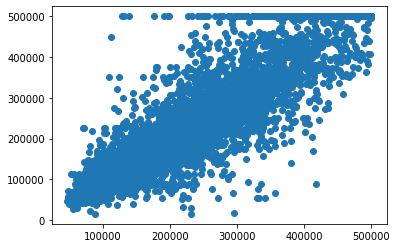

In [10]:
# Show people how to create and train a decision tree in sklearn
model = RandomForestRegressor()

# Fit the model
model.fit(X_train, Y_train)

# Inference
prediction = model.predict(X_test)
r2 = r2_score(Y_test, prediction)
print(r2)

# Plot
plt.scatter(prediction, Y_test)